In [8]:
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import torch
import torch.functional as F
import torch.nn as nn
from torch.optim import Adam
from time import time, sleep

from utils import *
from custom_pca import custom_pca
from video_loader import VideoLoader
from autoencoders import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Establishing baseline w.r.t PCA

In [ ]:
optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
losses[(ncomp, lr, wd)] = []
lr, wd, num_epoch = 0.001, 0.05, 30 # Tuned hyper-parameters
print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')

start = time()
for i in range(num_epoch):
    batch_losses = []
    for x in video:
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        batch_losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        losses[(ncomp, lr, wd)].append(np.mean(batch_losses))
fitting_time = sec2string(time() - start)
        
video.randit = video.skip_frame = 0
start = time()

reconstructed = []
for x in video:
    x = torch.from_numpy(x).float()
    reconstructed.append(net(x).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = sec2string(time() - start)

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
      
print(f'Time taken for fitting with {num_epoch+1} epochs:', fitting_time, 'sec')$à
print('Time taken to transform:', transform_time, 'sec')
losses = np.array(losses)
    
plot(range(1, num_epoch+1), [losses])

ncomp -> 50, lr -> 0.001, wd -> 0.05, nparams -> 6619186


In [4]:
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, grayscale=True)
num_epoch = 25

losses = {}
for ncomp in [10, 50]:
    net = PCAAutoEncoder((video.width, video.height), ncomp)
    for lr in [0.0005, 0.001]:
        for wd in [0.001, 0.01]:
            optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
            losses[(ncomp, lr, wd)] = []
            print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')
            for i in range(num_epoch):
                batch_losses = []
                for x in video:
                    x = torch.from_numpy(x).float()
                    x_reconstructed = net(x)
                    batch_loss = crit(x_reconstructed, x)
                    batch_losses.append(batch_loss.item())
                    optimizer.zero_grad()
                    batch_loss.backward()
                    optimizer.step()
                losses[(ncomp, lr, wd)].append(np.mean(batch_losses))
                #print(f'Average loss per pixel at epoch {i+1}:', losses[-1])
            print("Average error after %s epochs:" % num_epoch, losses[(ncomp, lr, wd)][-1])

ncomp -> 10, lr -> 0.0005, wd -> 0.001, nparams -> 1376266
Average error after 25 epochs: 58.204910142081125
ncomp -> 10, lr -> 0.0005, wd -> 0.01, nparams -> 1376266
Average error after 25 epochs: 32.91833536965506
ncomp -> 10, lr -> 0.001, wd -> 0.001, nparams -> 1376266
Average error after 25 epochs: 25.01471608025687
ncomp -> 10, lr -> 0.001, wd -> 0.01, nparams -> 1376266
Average error after 25 epochs: 23.20815978731428
ncomp -> 50, lr -> 0.0005, wd -> 0.001, nparams -> 6619186
Average error after 25 epochs: 42.18621744428362
ncomp -> 50, lr -> 0.0005, wd -> 0.01, nparams -> 6619186
Average error after 25 epochs: 21.786543709891184
ncomp -> 50, lr -> 0.001, wd -> 0.001, nparams -> 6619186
Average error after 25 epochs: 17.901950563703263
ncomp -> 50, lr -> 0.001, wd -> 0.01, nparams -> 6619186
Average error after 25 epochs: 16.674144506454468


In [7]:
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=3, grayscale=True)
num_epoch = 25

losses = {}
for ncomp in [50]:
    net = PCAAutoEncoder((video.width, video.height), ncomp)
    for lr in [0.001]:
        for wd in [0.01, 0.05, 0.1, 0.2]:
            optimizer = Adam(net.parameters(), lr=lr, weight_decay=wd)
            losses[(ncomp, lr, wd)] = []
            print(f'ncomp -> {ncomp}, lr -> {lr}, wd -> {wd}, nparams -> {sum([p.numel() for p in net.parameters()])}')
            for i in range(num_epoch):
                batch_losses = []
                for x in video:
                    x = torch.from_numpy(x).float()
                    x_reconstructed = net(x)
                    batch_loss = crit(x_reconstructed, x)
                    batch_losses.append(batch_loss.item())
                    optimizer.zero_grad()
                    batch_loss.backward()
                    optimizer.step()
                losses[(ncomp, lr, wd)].append(np.mean(batch_losses))
                #print(f'Average loss per pixel at epoch {i+1}:', losses[-1])
            print("Average error after %s epochs:" % num_epoch, losses[(ncomp, lr, wd)][-1])

ncomp -> 50, lr -> 0.001, wd -> 0.01, nparams -> 6619186
Average error after 25 epochs: 22.59322840826852
ncomp -> 50, lr -> 0.001, wd -> 0.05, nparams -> 6619186
Average error after 25 epochs: 15.610951457704816
ncomp -> 50, lr -> 0.001, wd -> 0.1, nparams -> 6619186
Average error after 25 epochs: 16.48225028174264
ncomp -> 50, lr -> 0.001, wd -> 0.2, nparams -> 6619186
Average error after 25 epochs: 18.666049071720668


Number of parameters: 6619186
Average loss per pixel at epoch 1: 142.00329840810676
Average loss per pixel at epoch 2: 61.758963233546204
Average loss per pixel at epoch 3: 61.021739658556484
Average loss per pixel at epoch 4: 58.660716910111276
Average loss per pixel at epoch 5: 53.87209611189993
Average loss per pixel at epoch 6: 47.00403484545256
Average loss per pixel at epoch 7: 47.38626821417557
Average loss per pixel at epoch 8: 41.13949966430664
Average loss per pixel at epoch 9: 38.92867238898026
Average loss per pixel at epoch 10: 40.36632718537983
Average loss per pixel at epoch 11: 35.86139899805973
Average loss per pixel at epoch 12: 35.27449954183478
Average loss per pixel at epoch 13: 31.793102264404297
Average loss per pixel at epoch 14: 30.52550842887477
Average loss per pixel at epoch 15: 29.145897614328486
Average loss per pixel at epoch 16: 28.57848965494256
Average loss per pixel at epoch 17: 27.207597230610094
Average loss per pixel at epoch 18: 26.832862251683284

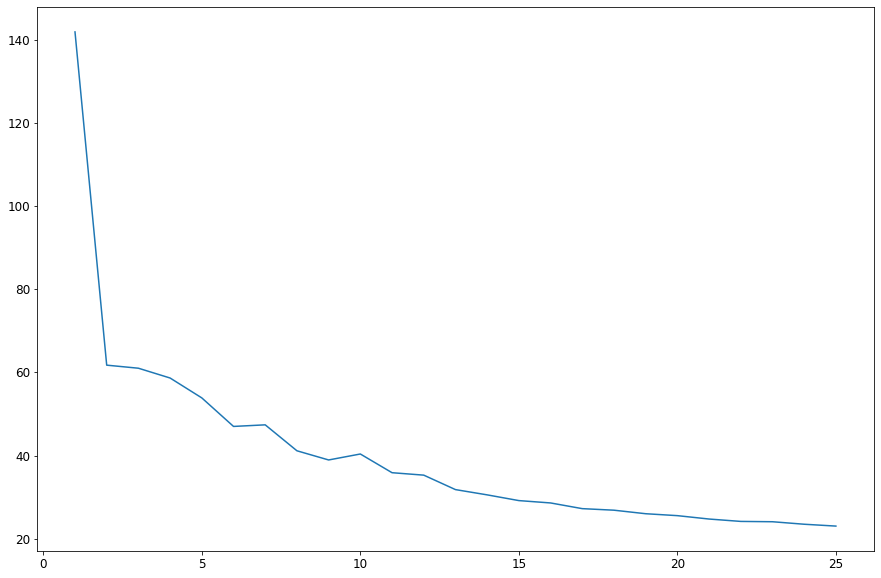

In [18]:
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=2, grayscale=True)
num_epoch = 25
net = PCAAutoEncoder((video.width, video.height), 50)
optimizer = Adam(net.parameters(), lr=0.0005, weight_decay=0.005)

print(f'Number of parameters:', sum([p.numel() for p in net.parameters()]))
losses = []
start = time()
for i in range(num_epoch):
    batch_losses = []
    num_in_batch = []
    for x in video:
        num_in_batch.append(x.shape[0])
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        batch_losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    losses.append(np.mean(batch_losses))
    print(f'Average loss per pixel at epoch {i+1}:', losses[-1])

fitting_time = time() - start
video.randit = video.skip_frame = 0

start = time()

reconstructed = []
for x in video:
    x = torch.from_numpy(x).float()
    reconstructed.append(net(x).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = time() - start

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
print("Error after %s epochs:" % num_epoch, exact_loss)
      
print(f'Time taken for fitting with {num_epoch+1} epochs:', fitting_time, 'sec')
print('Time taken to transform:', transform_time, 'sec')
losses = np.array(losses)
    
plot(range(1, num_epoch+1), [losses])

Number of parameters: 6619186
Average loss per pixel at epoch 1: 140.3683914385344
Average loss per pixel at epoch 2: 59.89795273228695
Average loss per pixel at epoch 3: 64.2743400774504
Average loss per pixel at epoch 4: 56.20037068818745
Average loss per pixel at epoch 5: 47.14252100492779
Average loss per pixel at epoch 6: 44.992759905363386
Average loss per pixel at epoch 7: 38.68874780755294
Average loss per pixel at epoch 8: 36.73343894356176
Average loss per pixel at epoch 9: 34.98434990330746
Average loss per pixel at epoch 10: 33.229543585526315
Average loss per pixel at epoch 11: 30.927652710362484
Average loss per pixel at epoch 12: 30.155069903323525
Average loss per pixel at epoch 13: 29.242477768345882
Average loss per pixel at epoch 14: 28.08175267671284
Average loss per pixel at epoch 15: 27.2427699440404
Average loss per pixel at epoch 16: 26.501801239816768
Average loss per pixel at epoch 17: 25.84408268175627
Average loss per pixel at epoch 18: 24.844291837591875
Av

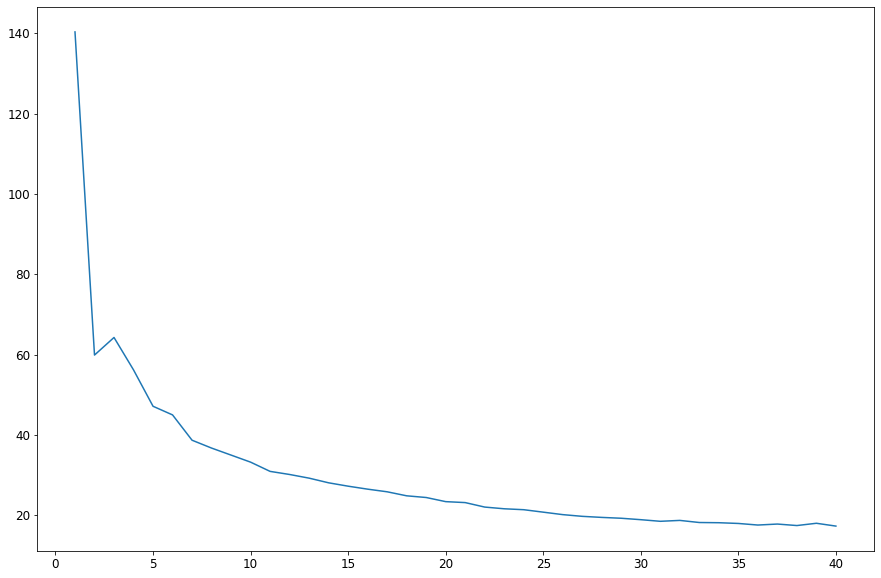

In [16]:
video = VideoLoader('data/big_sample_256.mp4', duration=5*60, randit=True, skip_frame=2, grayscale=True)
num_epoch = 40
net = PCAAutoEncoder((video.width, video.height), 50)
optimizer = Adam(net.parameters(), lr=0.0005, weight_decay=0.01)

print(f'Number of parameters:', sum([p.numel() for p in net.parameters()]))
losses = []
start = time()
for i in range(num_epoch):
    batch_losses = []
    num_in_batch = []
    for x in video:
        num_in_batch.append(x.shape[0])
        x = torch.from_numpy(x).float()
        x_reconstructed = net(x)
        batch_loss = crit(x_reconstructed, x)
        batch_losses.append(batch_loss.item())
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
    losses.append(np.mean(batch_losses))
    print(f'Average loss per pixel at epoch {i+1}:', losses[-1])

fitting_time = time() - start
video.randit = video.skip_frame = 0

start = time()

reconstructed = []
for x in video:
    x = torch.from_numpy(x).float()
    reconstructed.append(net(x).detach().numpy())
reconstructed = np.vstack(reconstructed)
transform_time = time() - start

exact_loss = reconstruction_error(reconstructed,
                                  video.get_all_frames())
print("Error after %s epochs:" % num_epoch, exact_loss)
      
print(f'Time taken for fitting with {num_epoch+1} epochs:', fitting_time, 'sec')
print('Time taken to transform:', transform_time, 'sec')
losses = np.array(losses)
    
plot(range(1, num_epoch+1), [losses])

In [15]:
#write_video('data/big_sample_pcaae_50.mp4', reconstructed, video.width, video.height, video.fps, grayscale=True)